In [30]:
import pandas as pd
import numpy as np
from data_master import DataMaster
from utils import func
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm import tqdm
master = DataMaster()
from utils.func import center
from quantstats.stats import sharpe


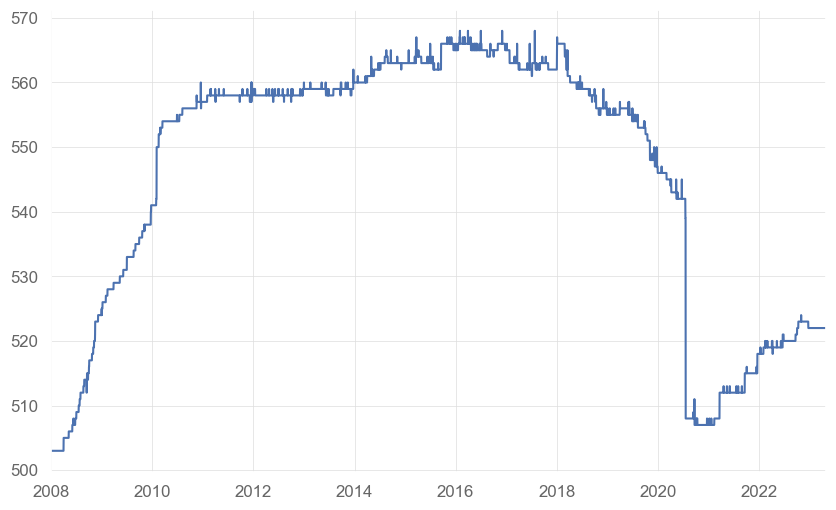

In [31]:
universe = master.baskets.get_index_historical_components('GSPC')
P = func.presence_matrix(universe).loc['2008':]
P.sum(1).plot()
market_data = pd.read_parquet('data/US/mkt_data.pq')
balance_sheet = pd.read_parquet('data/US/balance_sheets.pq')
GICS = pd.read_parquet('data/US/GICS.pq')
P = pd.read_parquet('data/US/universe_table.pq')
R = market_data['close'].unstack().reindex_like(P).pct_change()
income_statement = pd.read_parquet('data/US/income_statement.pq')
earnings = pd.read_parquet('data/US/earnings.pq')
cash_flow = pd.read_parquet('data/US/cash_flow.pq')

## Financial ratios :

- Net Debt / cash
- Debt-to-Equity Ratio: Total Debt / Total Equity
- Return on Equity (ROE): Net Income / Total Equity
- Return on Assets (ROA): Net Income / Total Assets
- Gross Profit Margin: (Total Revenue - Cost of Goods Sold) / Total Revenue
- Operating Profit Margin: Operating Income / Total Revenue
- Net Profit Margin: Net Income / Total Revenue
- Current Ratio: Current Assets / Current Liabilities
- Quick Ratio: (Current Assets - Inventory) / Current Liabilities
- Accounts Receivable Turnover: Total Revenue / Average Accounts Receivable
- Inventory Turnover: Cost of Goods Sold / Average Inventory
- Asset Turnover Ratio: Total Revenue / Total Assets
- Price-to-Earnings Ratio (P/E Ratio): Price per Share / Earnings per Share
- Dividend Yield: Annual Dividend per Share / Price per Share
- Price-to-Book Ratio (P/B Ratio): Price per Share / Book Value per Share
- Return on Investment (ROI): (Net Income + Interest Expense) / Total Assets
- Price/Earnings to Growth (PEG) Ratio: P/E Ratio / Annual Earnings per Share Growth Rate
- Price/Sales (P/S) Ratio: Market Capitalization / Total Revenue
- EBITDA Margin: EBITDA / Total Revenue
- EBITDA Coverage Ratio: EBITDA / Interest Expense
- Free Cash Flow (FCF) Yield: FCF per Share / Stock Price
- Return on Invested Capital (ROIC): EBIT / (Total Equity + Total Debt - Cash and Equivalents)
- Earnings Before Interest, Taxes, Depreciation, and Amortization per Share (EBITDA/Share): EBITDA / Shares Outstanding
- Price-to-Operating Cash Flow Ratio: Price per Share / Operating Cash Flow per Share
- Earnings Yield: Earnings per Share / Price per Share
- Debt-to-EBITDA Ratio: Total Debt / EBITDA


In [32]:
net_debt = balance_sheet['netDebt'].unstack().reindex_like(P).ffill().astype(float)
cash = balance_sheet['cash'].unstack().reindex_like(P).ffill().astype(float)

debt_cash = (net_debt/ cash).stack()
debt_cash

            Ticker
2008-01-31  A          0.535018
            ADI       -1.000000
            ADSK      -1.000000
            AMAT      -0.831242
            ANF       -0.632340
                        ...    
2023-04-06  YUM       27.265854
            ZBH        9.806931
            ZBRA      27.962963
            ZION       4.890728
            ZTS        1.696364
Length: 2470297, dtype: float64

In [33]:
total_debt =balance_sheet['shortLongTermDebtTotal'].unstack().reindex_like(P).ffill().astype(float)
total_equity = balance_sheet['commonStockTotalEquity'].unstack().reindex_like(P).ffill().astype(float)
debt_equity = (total_debt/total_equity).stack()

In [34]:
net_income = income_statement['netIncome'].unstack().reindex_like(P).ffill().astype(float)
total_assets = balance_sheet['totalAssets'].unstack().reindex_like(P).ffill().astype(float)
roa = (net_income/total_assets).stack()


In [35]:
roe =  (net_income/ total_equity).stack()

In [36]:
total_revenue = income_statement['totalRevenue'].unstack().reindex_like(P).ffill().astype(float)
cost_revenue = income_statement['costOfRevenue'].unstack().reindex_like(P).ffill().astype(float)
gross_margin = ((total_revenue - cost_revenue)/ total_revenue).stack()


In [37]:
operating_profit = income_statement['operatingIncome'].unstack().reindex_like(P).ffill().astype(float)
operating_margin = (operating_profit / total_revenue).stack()

In [38]:
current_assets = balance_sheet['totalCurrentAssets'].unstack().reindex_like(P).ffill().astype(float)
current_liab = balance_sheet['totalCurrentLiabilities'].unstack().reindex_like(P).ffill().astype(float)
current_ratio = (current_assets/ current_liab).stack()

In [39]:
inventory = balance_sheet['inventory'].unstack().reindex_like(P).ffill().astype(float)
quick_ratio = ((current_assets - inventory)/ current_liab).stack()

In [40]:
asset_turnover_ratio = (total_assets/ total_revenue).stack()

In [41]:
price = market_data['close'].unstack().reindex_like(P).ffill().astype(float)
eps =  earnings['epsActual'].unstack().reindex_like(P).ffill().astype(float)
pe_ratio = (price/eps).stack()

In [42]:
mkt_cap = market_data['MktCap'].unstack().reindex_like(P).ffill().astype(float)
ps_ratio = (mkt_cap/total_revenue).stack()

In [43]:
earnings_yield = (eps/price).stack()

In [44]:
ebitda = income_statement['ebitda'].unstack().reindex_like(P).ffill().astype(float)
debt_to_ebitda = (total_debt/ebitda).stack()

In [45]:
shares = balance_sheet['commonStockSharesOutstanding'].unstack().reindex_like(P).ffill().astype(float)
ebitda_share = (ebitda/shares).stack()

In [46]:
ebit = income_statement['ebitda'].unstack().reindex_like(P).ffill().astype(float)
totalAssets = balance_sheet['totalAssets'].unstack().reindex_like(P).ffill().astype(float)
totalCurrentAssets = balance_sheet['totalCurrentAssets'].unstack().reindex_like(P).ffill().astype(float)
roic = (ebit/(totalAssets - totalCurrentAssets)).stack()


In [47]:
totalAssets = balance_sheet['totalAssets'].unstack().reindex_like(P).ffill().astype(float)
totalLiabilities = balance_sheet['totalLiab'].unstack().reindex_like(P).ffill().astype(float)
book_value = totalAssets - totalLiabilities
shares = balance_sheet['commonStockSharesOutstanding'].unstack().reindex_like(P).ffill().astype(float)
book_value_share = book_value/ shares
close = market_data['close'].unstack().reindex_like(P).astype(float)
pb_ratio = (close/book_value_share).stack()

In [48]:
eps_actual = earnings['epsActual'].unstack().reindex_like(P).ffill().astype(float)
eps_estimate = earnings['epsEstimate'].unstack().reindex_like(P).ffill().astype(float)
eps_surprise = (eps_actual - eps_estimate).stack()

In [137]:
ratios = {
        'eps_surprise':eps_surprise,
        'pb_ratio':pb_ratio,
        'roic': roic,
        'ebitda_share':ebitda_share,
        'debt_to_ebitda': debt_to_ebitda,
        'earnings_yield': earnings_yield,
        'ps_ratio':ps_ratio,
        'pe_ratio':pe_ratio,
        'asset_turnover_ratio':asset_turnover_ratio,
        'quick_ratio':quick_ratio,
        'current_ratio':current_ratio,
        'operating_margin':operating_margin,
        'gross_margin':gross_margin,
        'roe':roe,
        'roa':roa,
        'debt_equity':debt_equity,
        'debt_cash':debt_cash

        }

In [138]:
result_df = pd.DataFrame()

# Iterate through the dictionary and add each DataFrame as a new column
for key, df in ratios.items():
    print(key)
    df = pd.DataFrame({key:df})
    df.index.names = ['Date','Ticker']

    # Unstack the MultiIndex to create columns for each level
    # Append the DataFrame to the result DataFrame
    ratios[key] = df

# Print the result DataFrame
print(result_df)

eps_surprise
pb_ratio
roic
ebitda_share
debt_to_ebitda
earnings_yield
ps_ratio
pe_ratio
asset_turnover_ratio
quick_ratio
current_ratio
operating_margin
gross_margin
roe
roa
debt_equity
debt_cash
Empty DataFrame
Columns: []
Index: []


In [139]:
data_raw = pd.DataFrame( {'close':market_data['close'].unstack().reindex_like(P).stack()})
features = list(ratios)
for col in tqdm(features):
    data_raw[col] = ratios[col]

data_raw

100%|██████████| 17/17 [00:13<00:00,  1.26it/s]


close  eps_surprise   pb_ratio      roic  ebitda_share  \
           Ticker                                                              
2008-01-01 ZMH     331.0000           NaN        NaN       NaN           NaN   
2008-01-02 A        36.2888           NaN        NaN       NaN           NaN   
           AA       36.1300           NaN        NaN       NaN           NaN   
           AAL      13.3200           NaN        NaN       NaN           NaN   
           AAP      37.5900           NaN        NaN       NaN           NaN   
...                     ...           ...        ...       ...           ...   
2023-04-05 YUM     131.9400         -0.04  -4.463903  0.144359      2.089965   
           ZBH     128.5900         -0.06   2.207351  0.026853      2.145031   
           ZBRA    300.1500          0.20   5.892051  0.053434      5.713425   
           ZION     28.6300         -0.16   0.104405  0.004557      2.376629   
           ZTS     167.6500         -0.08  16.869287  0.117366      1.782136   

                   debt_to_ebitda  earnings_yield   ps_ratio    pe_ratio  \
           Ticker                                                          
2008-01-01 ZMH                NaN             NaN        NaN         NaN   
2008-01-02 A                  NaN             NaN        NaN         NaN   
           AA                 NaN             NaN        NaN         NaN   
           AAL                NaN             NaN        NaN         NaN   
           AAP                NaN             NaN        NaN         NaN   
...                           ...             ...        ...         ...   
2023-04-05 YUM          19.187086        0.008261  23.190488  121.045872   
           ZBH          13.066061        0.012287  16.110658   81.386076   
           ZBRA          7.872483        0.013726  11.684797   72.851942   
           ZION          9.994382        0.048900   5.870914   20.450000   
           ZTS           8.072967        0.007217  39.147121  138.553719   

                   asset_turnover_ratio  quick_ratio  current_ratio  \
           Ticker                                                     
2008-01-01 ZMH                      NaN          NaN            NaN   
2008-01-02 A                        NaN          NaN            NaN   
           AA                       NaN          NaN            NaN   
           AAL                      NaN          NaN            NaN   
           AAP                      NaN          NaN            NaN   
...                                 ...          ...            ...   
2023-04-05 YUM                 3.523780     1.257235       1.282154   
           ZBH                12.775961     1.047959       1.975171   
           ZBRA                5.404935     0.509889       0.902557   
           ZION              116.653465     1.506066       1.507106   
           ZTS                 6.830170     1.475000       2.274653   

                   operating_margin  gross_margin         roe       roa  \
           Ticker                                                         
2008-01-01 ZMH                  NaN           NaN         NaN       NaN   
2008-01-02 A                    NaN           NaN         NaN       NaN   
           AA                   NaN           NaN         NaN       NaN   
           AAL                  NaN           NaN         NaN       NaN   
           AAP                  NaN           NaN         NaN       NaN   
...                             ...           ...         ...       ...   
2023-04-05 YUM             0.332927      0.496341   14.391304  0.057276   
           ZBH             0.146904      0.707630   62.580645  0.009094   
           ZBRA            0.146589      0.455733  170.000000  0.022825   
           ZION            0.393211      1.072136    0.084600  0.002631   
           ZTS             0.361139      0.696803  105.800000  0.038687   

                   debt_equity  debt_cash  
           Ticker                          
2008

In [140]:
data_scale = data_raw.copy()
for column in tqdm(features) :
    sub_df = data_raw[column].unstack().reindex_like(P).ffill()
    sub_df_rank_cs = sub_df[P].rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).round(2)
    sub_df_rank_cs = sub_df_rank_cs.fillna(sub_df_rank_cs.mean(1))[P]
    data_scale[column+'_cs'] = sub_df_rank_cs.stack()
    sub_df_rank_ts = sub_df_rank_cs.rolling(252,min_periods=10).rank(pct=True,ascending=True).clip(0.01,0.99).round(2)
    sub_df_rank_ts = sub_df_rank_ts.fillna(sub_df_rank_ts.mean(1))[P]
    data_scale[column+'_ts'] = sub_df_rank_ts.stack()
    data_scale.drop(column,axis=1,inplace=True)
data_model = data_scale.dropna()


 35%|███▌      | 6/17 [00:42<01:18,  7.18s/it]

In [131]:
# data_model.to_parquet('data_model.pq')
# data_model = pd.read_parquet('data/US/data_model.pq')
# data_model['close']= R[P].rank(1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf).round(2).stack()
# data_model = data_model.dropna()

In [132]:
Y = data_model.iloc[:,0]
X= data_model.iloc[:,1:]
X_train = X.loc[:'2018']
Y_train = Y.loc[:'2018']
X_test = X.loc['2018':]
Y_test = Y.loc['2018':]
X_test

eps_surprise_cs  eps_surprise_ts  pb_ratio_cs  pb_ratio_ts  \
           Ticker                                                               
2018-01-02 A                  0.28             0.47         0.24        -0.44   
           AA                -0.25             1.52        -1.26         2.33   
           AAPL              -0.14             2.33         1.51        -1.09   
           ABBV              -0.25             1.73         1.49         0.53   
           ABC                0.33            -0.20         0.80        -0.09   
...                            ...              ...          ...          ...   
2023-04-05 XYL                0.28            -0.81         0.55        -0.07   
           YUM               -0.52             2.26        -1.52         0.45   
           ZBH               -0.59            -2.33        -0.34         1.17   
           ZBRA               0.34             0.53         0.58        -0.62   
           ZTS               -0.66             0.79         1.45        -0.18   

                   roic_cs  roic_ts  ebitda_share_cs  ebitda_share_ts  \
           Ticker                                                       
2018-01-02 A          0.55     1.71            -0.79             0.47   
           AA        -0.45    -0.84             0.29             1.34   
           AAPL       0.40    -0.89            -1.02            -1.56   
           ABBV       0.37     0.59             0.14             0.41   
           ABC       -0.56    -1.11            -0.41            -2.15   
...                    ...      ...              ...              ...   
2023-04-05 XYL       -0.92    -1.36            -1.23             0.05   
           YUM        1.35     0.83            -0.09             2.10   
           ZBH       -0.48     0.17            -0.05             1.83   
           ZBRA       0.23     0.53             1.06             0.78   
           ZTS        1.07    -0.14            -0.26             0.77   

                   debt_to_ebitda_cs  debt_to_ebitda_ts  ...  gross_margin_cs  \
           Ticker                                        ...                    
2018-01-02 A                   -0.53              -0.98  ...             0.32   
           AA                  -1.07               1.79  ...            -1.13   
           AAPL                -0.39               1.91  ...            -0.17   
           ABBV                 0.33               0.02  ...             1.15   
           ABC                  0.32               0.66  ...            -2.32   
...                              ...                ...  ...              ...   
2023-04-05 XYL                  1.41               0.76  ...            -0.23   
           YUM                  0.86              -0.35  ...             0.23   
           ZBH                  0.38              -0.04  ...             1.00   
           ZBRA                -0.29              -0.02  ...             0.09   
           ZTS                 -0.25              -0.03  ...             0.93   

                   gross_margin_ts  roe_cs  roe_ts  roa_cs  roa_ts  \
           Ticker                                                    
2018-01-02 A                 -0.87    0.26   -0.33    0.52    0.11   
           AA                 2.09    0.10    0.66   -0.78    1.28   
           AAPL              -0.48   -0.90   -0.30    0.74   -0.38   
           ABBV               1.10    0.66    0.39    0.92    0.57   
           ABC                0.76   -0.04   -0.42   -1.30   -0.06   
...                            ...     ...     ...     ...     ...   
2023-04-05 XYL                2.33   -0.27   -0.91   -1.21   -0.32   
           YUM                2.33   -0.07    0.12    1.55    0.07   
           ZBH                2.33    0.22    2.33   -0.40    0.63   
           ZBRA               2.33    0.66    0.78    0.40    0.29   
           ZTS                0.81    0.41   -0.00    1.01    0.55   

                   debt_equity_cs  debt_equity_ts 

In [134]:
dates_test = pd.to_datetime(X.loc['2023':].index.get_level_values(0)).unique()
results = {}
from tqdm import tqdm
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
result = pd.DataFrame().reindex_like(P)
for i,date in (enumerate(tqdm(dates_test[1:-1]))):
    curr_date = str(date.date())
    next_date = str(dates_test[i+1].date())
    X_train = X.loc[:curr_date]
    Y_train = Y.loc[:curr_date]
    tickers = X_train.loc[curr_date].index.tolist()
    for ticker in tickers:
        x_train = X_train.xs(ticker,level=1)
        y_train = Y_train.xs(ticker,level=1)
        neigh = KNeighborsRegressor(n_neighbors=9).fit(x_train,y_train)
        pred = neigh.predict(pd.DataFrame(X.loc[(curr_date,ticker)]).T)[0]
        result.loc[next_date,ticker] = pred

  8%|▊         | 5/63 [01:10<13:33, 14.03s/it]


KeyboardInterrupt: 

C:\Users\marti\AppData\Local\Temp\ipykernel_152616\3708892869.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  result = result.dropna(0,'all')


ValueError: zero-size array to reduction operation fmin which has no identity

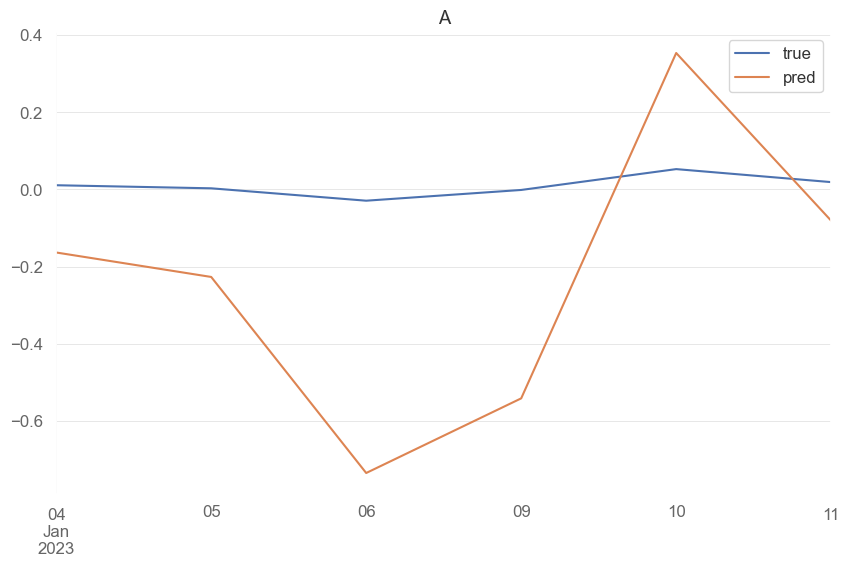

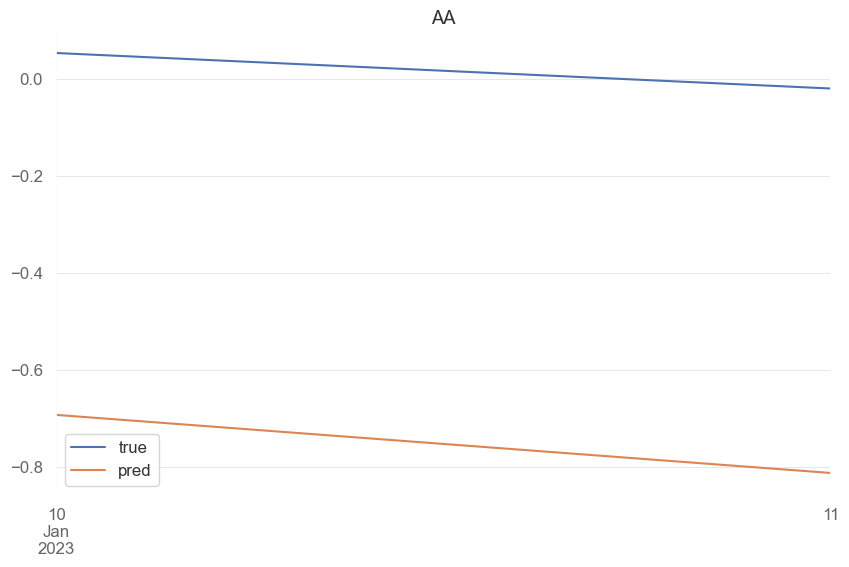

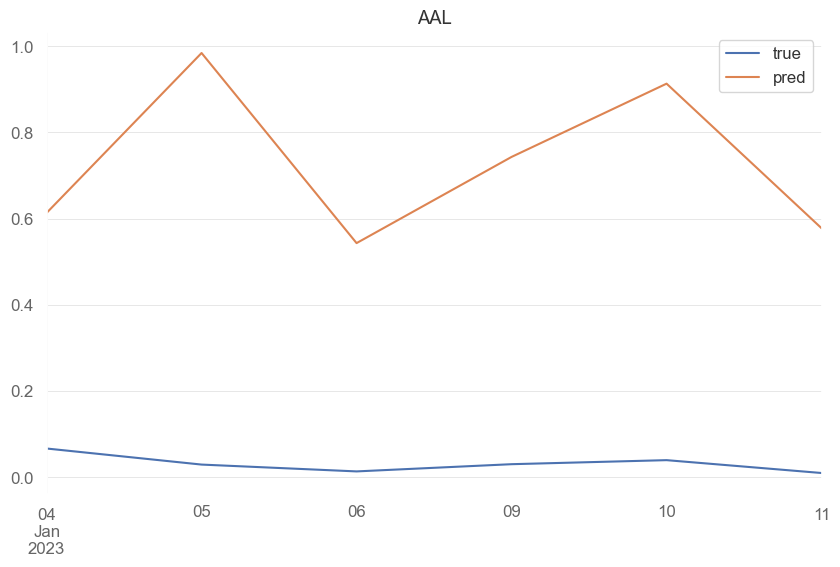

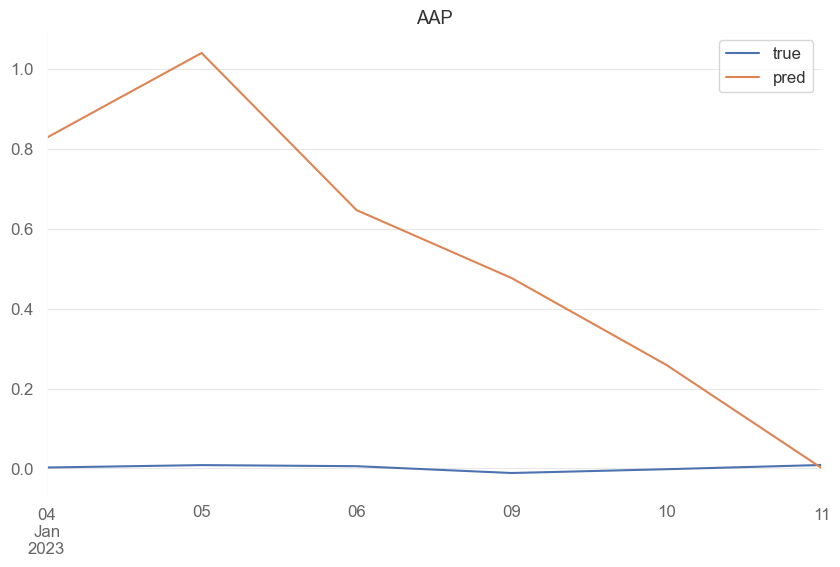

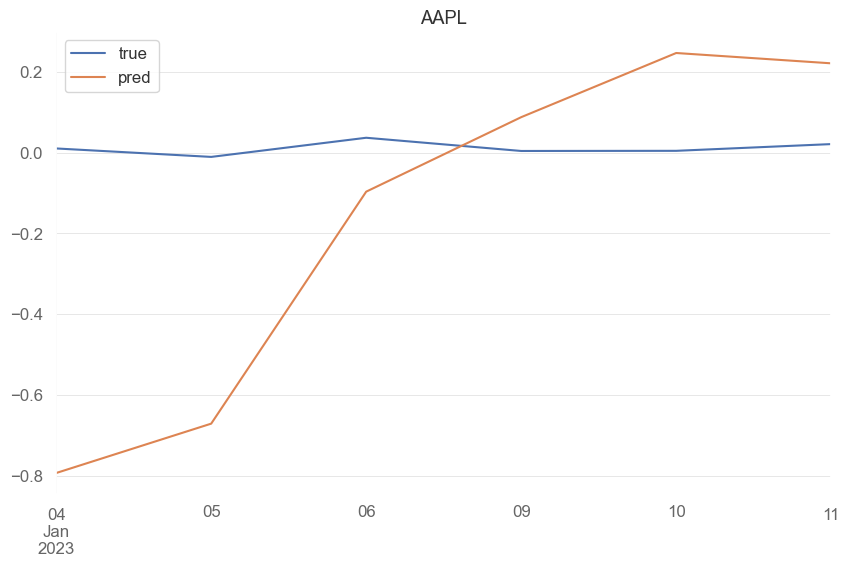

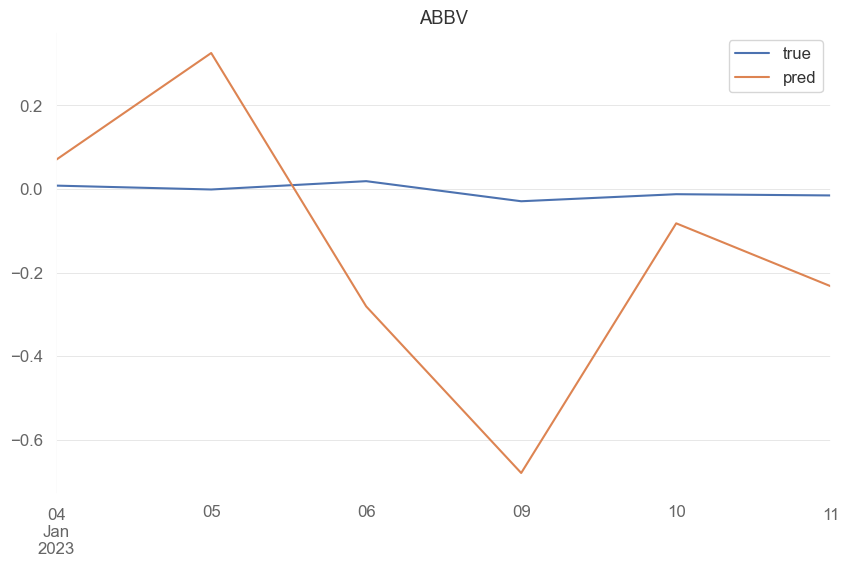

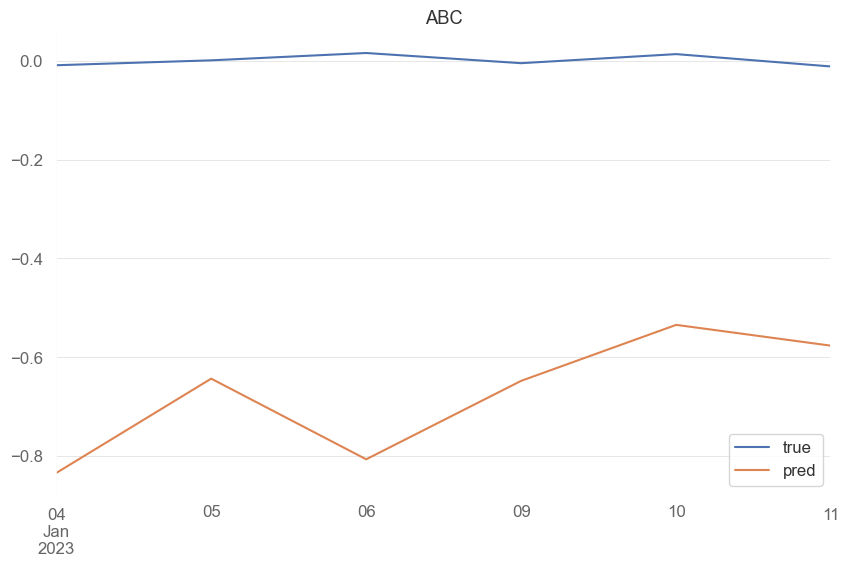

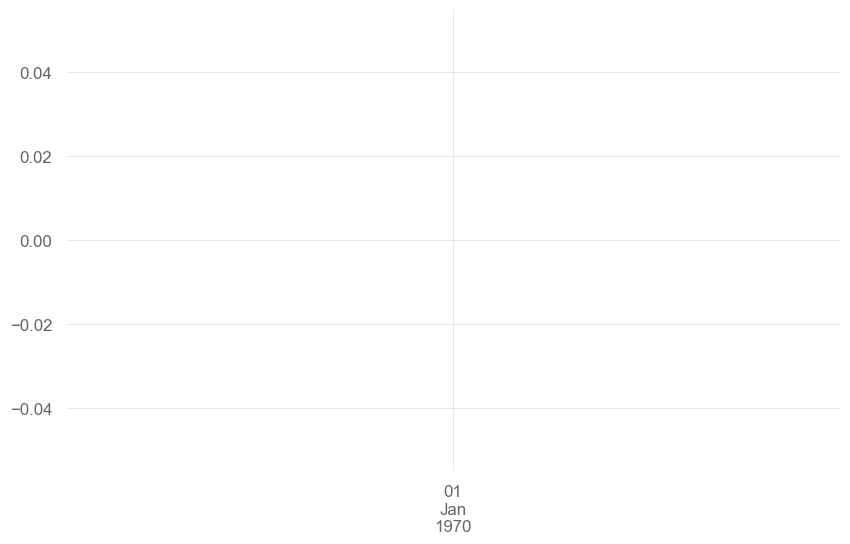

In [135]:
result = result.dropna(0,'all')
for ticker in result.columns.tolist():
    df = pd.DataFrame({'true':R[ticker],'pred':result[ticker]}).dropna()
    df.plot(title=ticker)

In [106]:
str(curr_date.date())

'2023-01-05'

In [68]:
result = pd.DataFrame().reindex_like(P)
for i,date in (enumerate(tqdm(dates_test[1:-1]))):
    curr_date = date
    previous_date = dates_test[i-1]
    next_date = dates_test[i+1]
    X_train = X.loc[:previous_date]
    Y_train = Y.loc[:previous_date]
    tickers = X_train.loc[previous_date].index.tolist()
    for ticker in tickers:
        x_train = X_train.xs(ticker,level=1)
        y_train = Y_train.xs(ticker,level=1)
        neigh = KNeighborsRegressor(n_neighbors=5).fit(x_train,y_train)
        pred = neigh.predict(pd.DataFrame(X.loc[(curr_date,ticker)]).T)[0]

        result.loc[curr_date,ticker] = pred


100%|██████████| 2077/2077 [00:00<00:00, 2870.27it/s]


In [74]:
tickers = X_train.loc[previous_date].index.tolist()
for ticker in tickers:
    x_train = X_train.xs(ticker,level=1)
    y_train = Y_train.xs(ticker,level=1)
    neigh = KNeighborsRegressor(n_neighbors=5).fit(x_train,y_train)
    pred = neigh.predict(pd.DataFrame(X.loc[(curr_date,ticker)]).T)[0]

    result.loc[curr_date,ticker] = pred


In [76]:
neigh = KNeighborsRegressor(n_neighbors=5).fit(x_train,y_train)
pred = neigh.predict(X.loc[curr_date].loc(ticker))

ValueError: No axis named ZTS for object type DataFrame

In [86]:
pred = neigh.predict(pd.DataFrame(X.loc[(curr_date,ticker)]).T)[0]
true = Y.loc[(next_date,ticker)]
pred

151.748

C:\Users\marti\AppData\Local\Temp\ipykernel_152616\2303244168.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  signal = pd.DataFrame(results).T.reindex_like(P)[P].dropna(0,'all')
C:\Users\marti\AppData\Local\Temp\ipykernel_152616\2303244168.py:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  signal = signal[P].groupby(GICS['gicgrp'],axis=1).apply(center)
C:\Users\marti\AppData\Local\Temp\ipykernel_152616\2303244168.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  pnl = (signal[P].shift()*R).dropna(0,'all').sum(1)


Sharpe      0.3
Turnover    0.4
biais       0.3
dtype: float64

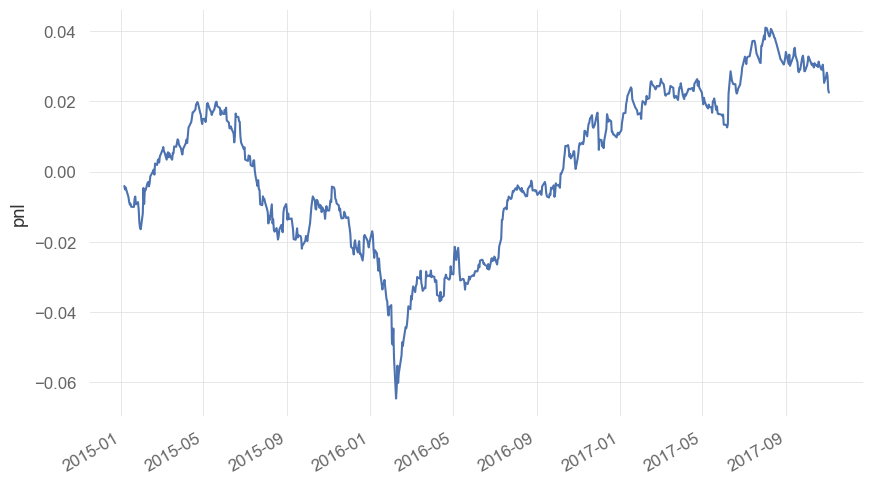

In [29]:
signal = pd.DataFrame(results).T.reindex_like(P)[P].dropna(0,'all')
signal = signal[P].rank(axis=1,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf)
signal[signal.abs()<0.5] = None
signal = signal[P].groupby(GICS['gicgrp'],axis=1).apply(center)
signal = signal[P].div(signal.abs().sum(1),0)

pnl = (signal[P].shift()*R).dropna(0,'all').sum(1)
sr = sharpe(pnl)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
pnl.cumsum().plot()
plt.ylabel('pnl')
pd.Series({'Sharpe':sr,'Turnover':turnover,'biais':pnl.mean()*1e4}).round(1)

In [113]:
0.04*(253/34)*3

0.8929411764705883